# 🎯 Person Detection for ESP32-CAM

Этот ноутбук обучает **легковесную модель** для обнаружения и **локализации** человека в кадре ESP32-CAM.

## Подход

Полноценный object detection (YOLO/SSD) слишком тяжёл для ESP32-CAM. Вместо этого используем **grid-based classification**:

1. Делим кадр 96×96 на сетку **3×3** (9 регионов)
2. Модель предсказывает для каждого региона: **есть человек или нет** + **confidence**
3. По активным регионам вычисляем **направление** для поворота камеры (сервоприводом)

Это даёт нам:
- Понимание, **где** в кадре человек (лево/центр/право, верх/центр/низ)
- Модель всего ~10-30 КБ в квантованном виде
- Инференс ~50-100мс на ESP32

## Что понадобится
- Датасет в формате YOLO (bounding boxes) — как ваш `person-indoor`
- GPU runtime в Colab (Runtime → Change runtime type → T4 GPU)

---
## 1. Установка зависимостей

In [ ]:
!pip install -q tensorflow opencv-python-headless albumentations
import numpy as np
import cv2
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import shutil

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
## 2. Загрузка датасета

In [ ]:
#@title Выберите способ загрузки датасета { run: "auto" }
upload_method = "google_drive"  #@param ["upload_zip", "roboflow_api", "google_drive"]

DATASET_DIR = "/content/dataset"

if upload_method == "upload_zip":
    print("Загрузите ZIP-архив с датасетом:")
    uploaded = files.upload()
    zip_name = list(uploaded.keys())[0]
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(DATASET_DIR)
    print(f"Распаковано в {DATASET_DIR}")

elif upload_method == "roboflow_api":
    # Установите свои параметры Roboflow
    !pip install -q roboflow
    from roboflow import Roboflow
    rf = Roboflow(api_key="YOUR_API_KEY")  # ← Вставьте ваш API ключ
    project = rf.workspace("mainworkspace-vnqbv").project("person-indoor-j1xd0-0old0")
    version = project.version(1)
    ds = version.download("yolov8", location=DATASET_DIR)

elif upload_method == "google_drive":
    from google.colab import drive
    drive.mount('/content/drive')
    # Укажите путь к датасету на Google Drive
    DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/dataset.zip"  # ← Измените путь
    with zipfile.ZipFile(DRIVE_PATH, 'r') as z:
        z.extractall(DATASET_DIR)

# Найдём структуру датасета
print("\nСтруктура датасета:")
for root, dirs, fls in os.walk(DATASET_DIR):
    level = root.replace(DATASET_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    if level < 2:
        for f in fls[:3]:
            print(f'{indent}  {f}')
        if len(fls) > 3:
            print(f'{indent}  ... и ещё {len(fls)-3} файлов')

Mounted at /content/drive

Структура датасета:
dataset/
  dataset/
    data.yaml
    README.roboflow.txt
    README.dataset.txt
    train/
      images/
      labels/
    test/
      images/
      labels/
    valid/
      images/
      labels/


In [ ]:
#@title Автоопределение путей к данным

def find_dataset_paths(base_dir):
    """Автоматически находит папки train/valid/test с images и labels."""
    paths = {}
    for split in ['train', 'valid', 'val', 'test']:
        for root, dirs, _ in os.walk(base_dir):
            if os.path.basename(root) == split:
                img_dir = os.path.join(root, 'images')
                lbl_dir = os.path.join(root, 'labels')
                if os.path.isdir(img_dir) and os.path.isdir(lbl_dir):
                    key = 'valid' if split == 'val' else split
                    paths[key] = {'images': img_dir, 'labels': lbl_dir}
    return paths

dataset_paths = find_dataset_paths(DATASET_DIR)
for split, p in dataset_paths.items():
    n_imgs = len(glob.glob(os.path.join(p['images'], '*')))
    n_lbls = len(glob.glob(os.path.join(p['labels'], '*.txt')))
    print(f"{split}: {n_imgs} images, {n_lbls} labels")
    print(f"  images: {p['images']}")
    print(f"  labels: {p['labels']}")

train: 1590 images, 1590 labels
  images: /content/dataset/dataset/train/images
  labels: /content/dataset/dataset/train/labels
valid: 216 images, 216 labels
  images: /content/dataset/dataset/valid/images
  labels: /content/dataset/dataset/valid/labels
test: 106 images, 106 labels
  images: /content/dataset/dataset/test/images
  labels: /content/dataset/dataset/test/labels


---
## 3. Конвертация YOLO bbox → Grid Labels

Преобразуем bounding boxes в сетку 3×3: для каждой ячейки определяем, содержит ли она часть человека.

In [ ]:
# Параметры модели
IMG_SIZE = 96       # Размер входа модели (96x96)
GRID_SIZE = 3       # Сетка 3x3 = 9 регионов
NUM_CELLS = GRID_SIZE * GRID_SIZE  # 9
PERSON_CLASS = 0    # Класс 'person' в YOLO-разметке

# Порог IoU: если bbox перекрывает ячейку хотя бы на X%, считаем что человек там есть
IOU_THRESHOLD = 0.05

def yolo_to_grid(label_path, img_w, img_h, grid_size=3, target_class=0):
    """
    Читает YOLO label файл и конвертирует bbox в grid-based метки.

    Returns:
        grid: numpy array (grid_size, grid_size) с 0/1
        has_person: bool — есть ли человек на изображении вообще
    """
    grid = np.zeros((grid_size, grid_size), dtype=np.float32)
    has_person = False

    if not os.path.exists(label_path):
        return grid, has_person

    cell_w = 1.0 / grid_size
    cell_h = 1.0 / grid_size

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(parts[0])
            if cls != target_class:
                continue

            has_person = True
            # YOLO format: x_center, y_center, width, height (normalized 0-1)
            xc, yc, w, h = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
            x1 = xc - w / 2
            y1 = yc - h / 2
            x2 = xc + w / 2
            y2 = yc + h / 2

            # Определяем, какие ячейки сетки перекрывает bbox
            for gy in range(grid_size):
                for gx in range(grid_size):
                    # Границы ячейки (normalized)
                    cx1 = gx * cell_w
                    cy1 = gy * cell_h
                    cx2 = (gx + 1) * cell_w
                    cy2 = (gy + 1) * cell_h

                    # Площадь пересечения
                    inter_x1 = max(x1, cx1)
                    inter_y1 = max(y1, cy1)
                    inter_x2 = min(x2, cx2)
                    inter_y2 = min(y2, cy2)

                    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
                        inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
                        cell_area = cell_w * cell_h
                        # Доля ячейки, покрытая bbox
                        coverage = inter_area / cell_area
                        if coverage > IOU_THRESHOLD:
                            grid[gy, gx] = 1.0

    return grid, has_person

print("Функция yolo_to_grid() готова.")
print(f"Сетка: {GRID_SIZE}x{GRID_SIZE} = {NUM_CELLS} ячеек")

Функция yolo_to_grid() готова.
Сетка: 3x3 = 9 ячеек


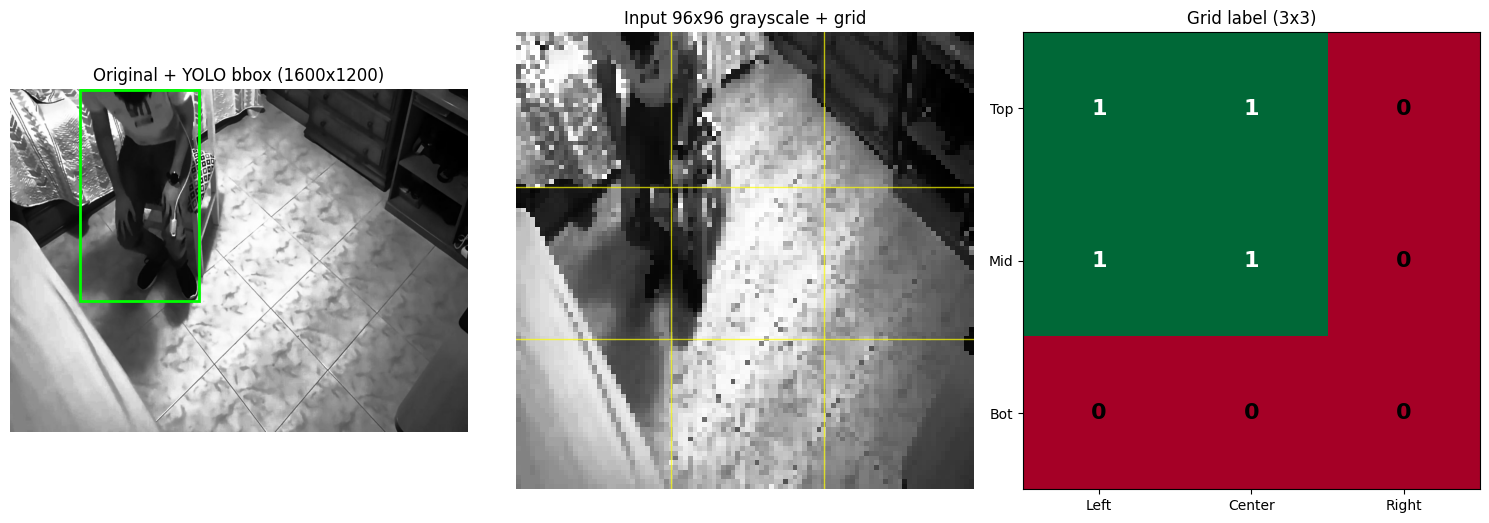

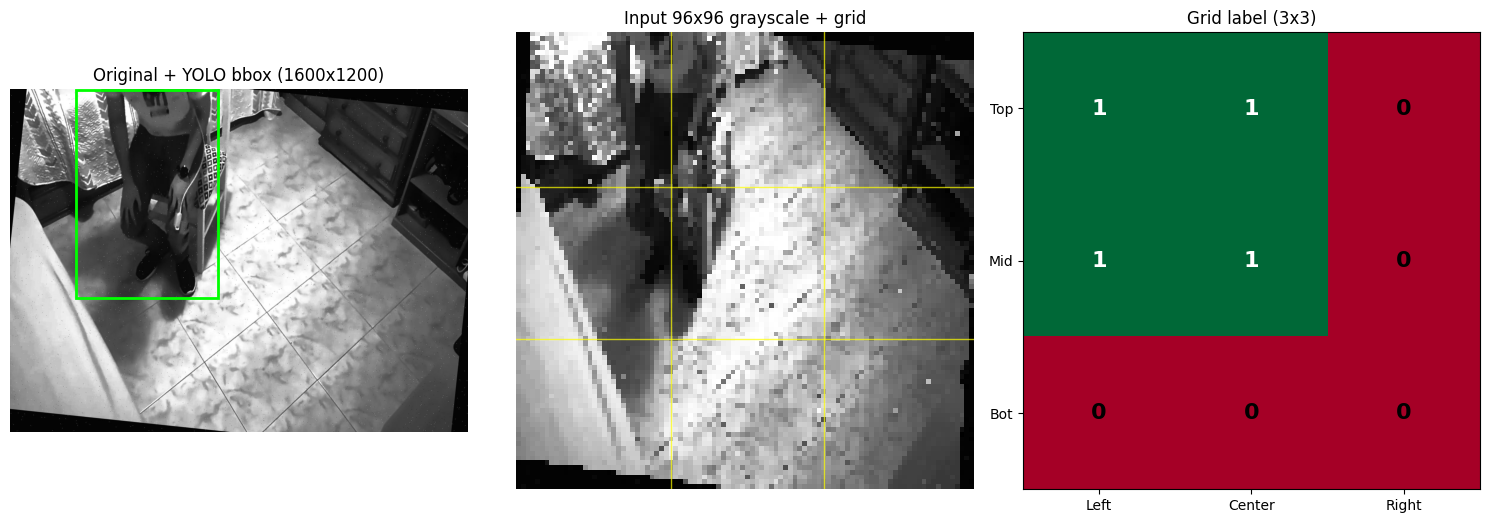

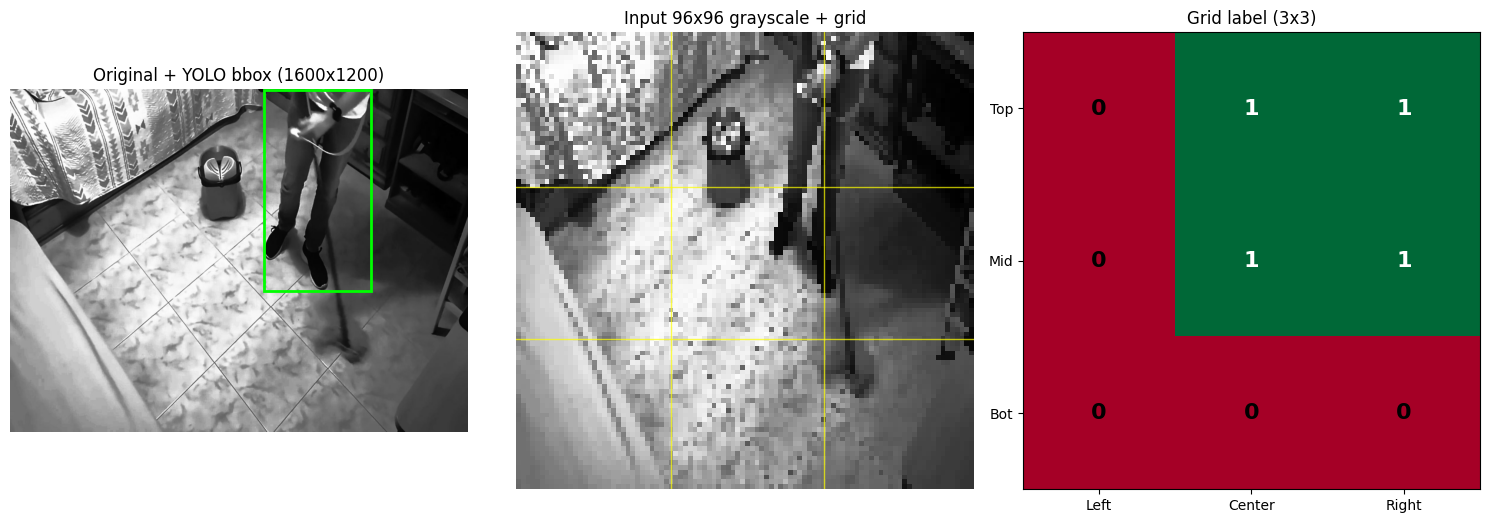

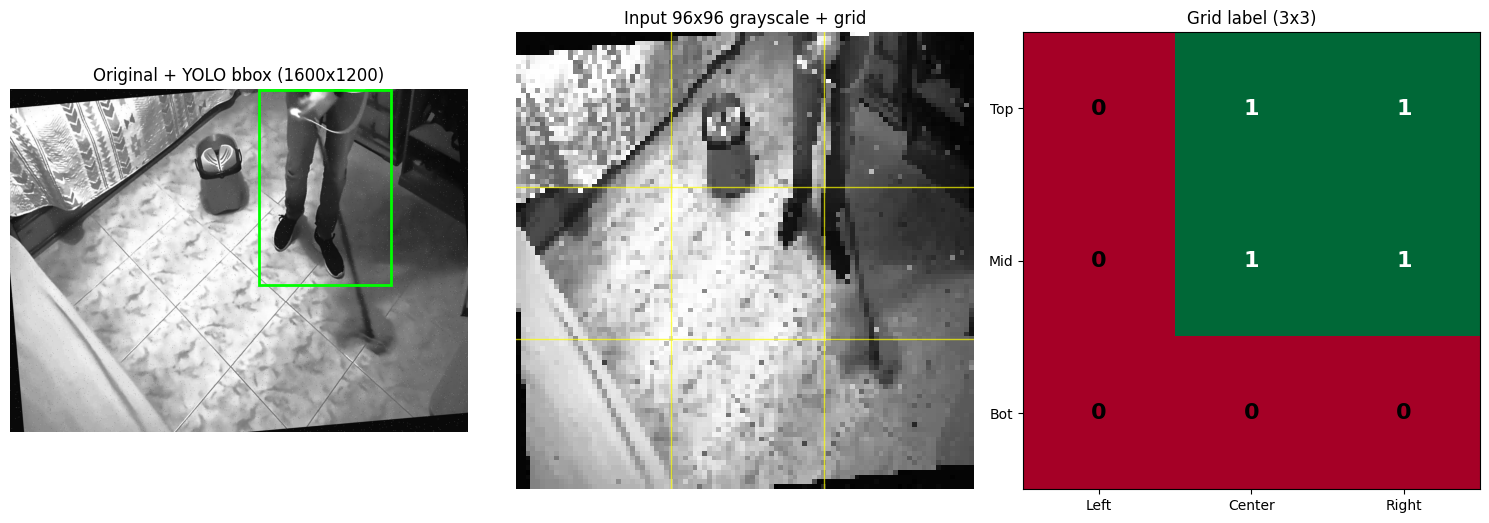

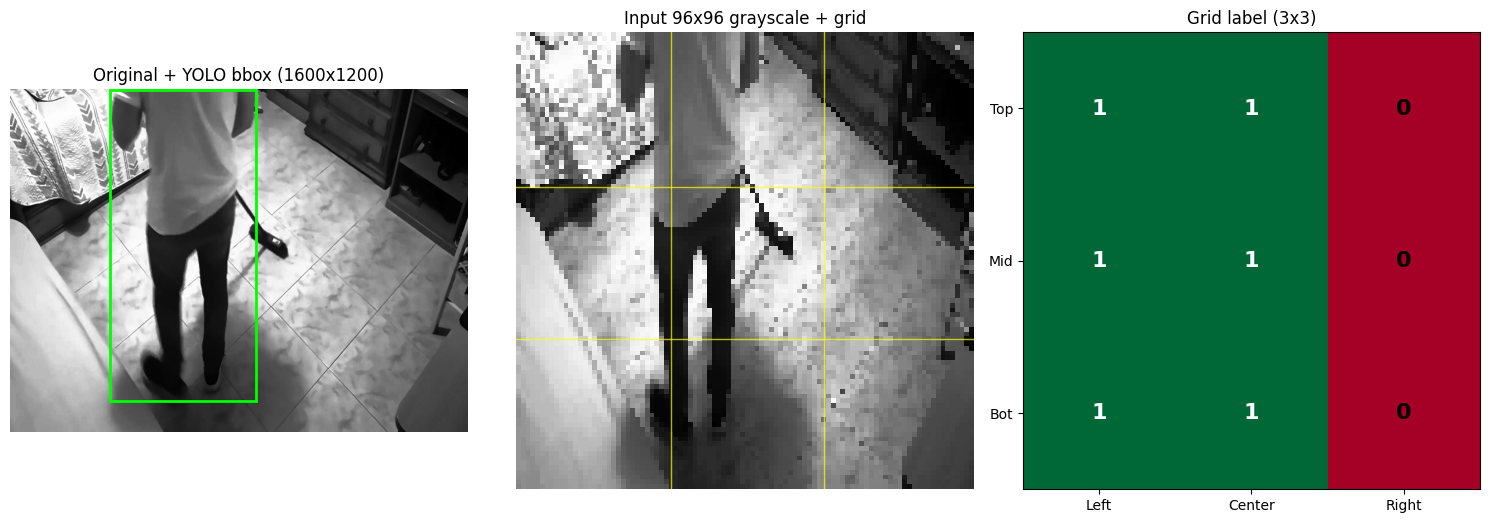

In [ ]:
#@title Визуализация: как bbox маппится на сетку

def visualize_grid_mapping(img_path, label_path, grid_size=3):
    """Показывает изображение с bbox и соответствующую сетку."""
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    grid, has_person = yolo_to_grid(label_path, w, h, grid_size, PERSON_CLASS)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1. Оригинал с bbox
    ax = axes[0]
    ax.imshow(img)
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5 and int(parts[0]) == PERSON_CLASS:
                    xc, yc, bw, bh = [float(x) for x in parts[1:5]]
                    x1_px = int((xc - bw/2) * w)
                    y1_px = int((yc - bh/2) * h)
                    w_px = int(bw * w)
                    h_px = int(bh * h)
                    rect = plt.Rectangle((x1_px, y1_px), w_px, h_px,
                                        linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
    ax.set_title(f"Original + YOLO bbox ({w}x{h})")
    ax.axis('off')

    # 2. Resized 96x96 grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
    ax = axes[1]
    ax.imshow(img_resized, cmap='gray')
    # Рисуем сетку
    cell_px = IMG_SIZE // grid_size
    for i in range(1, grid_size):
        ax.axhline(y=i*cell_px, color='yellow', linewidth=1, alpha=0.7)
        ax.axvline(x=i*cell_px, color='yellow', linewidth=1, alpha=0.7)
    ax.set_title(f"Input {IMG_SIZE}x{IMG_SIZE} grayscale + grid")
    ax.axis('off')

    # 3. Grid labels
    ax = axes[2]
    ax.imshow(grid, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    for gy in range(grid_size):
        for gx in range(grid_size):
            val = grid[gy, gx]
            color = 'white' if val > 0.5 else 'black'
            ax.text(gx, gy, f"{val:.0f}", ha='center', va='center',
                   fontsize=16, fontweight='bold', color=color)
    ax.set_title(f"Grid label ({grid_size}x{grid_size})")
    ax.set_xticks(range(grid_size))
    ax.set_yticks(range(grid_size))
    ax.set_xticklabels(['Left', 'Center', 'Right'])
    ax.set_yticklabels(['Top', 'Mid', 'Bot'])

    plt.tight_layout()
    plt.show()

# Покажем несколько примеров
if 'train' in dataset_paths:
    img_dir = dataset_paths['train']['images']
    lbl_dir = dataset_paths['train']['labels']
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    for img_path in img_files[:5]:
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + '.txt')
        visualize_grid_mapping(img_path, lbl_path, GRID_SIZE)

---
## 4. Подготовка данных для обучения

In [ ]:
def load_dataset(split_paths, img_size=96, grid_size=3, augment=False):
    """
    Загружает изображения и конвертирует YOLO labels в grid labels.

    Returns:
        X: numpy array (N, img_size, img_size, 1) float32 [0..1]
        y: numpy array (N, grid_size*grid_size) float32 [0 or 1]
    """
    img_dir = split_paths['images']
    lbl_dir = split_paths['labels']

    X_list = []
    y_list = []

    img_files = sorted(glob.glob(os.path.join(img_dir, '*.*')))
    skipped = 0

    for img_path in img_files:
        ext = os.path.splitext(img_path)[1].lower()
        if ext not in ['.jpg', '.jpeg', '.png', '.bmp']:
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            skipped += 1
            continue

        h, w = img.shape[:2]
        base = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base + '.txt')

        # Конвертируем bbox в grid
        grid, _ = yolo_to_grid(lbl_path, w, h, grid_size, PERSON_CLASS)

        # Resize
        img_resized = cv2.resize(img, (img_size, img_size))
        img_norm = img_resized.astype(np.float32) / 255.0

        X_list.append(img_norm)
        y_list.append(grid.flatten())

        # Аугментация: горизонтальное отзеркаливание
        if augment:
            img_flip = cv2.flip(img_resized, 1)  # horizontal flip
            img_flip_norm = img_flip.astype(np.float32) / 255.0
            grid_flip = np.flip(grid, axis=1).copy()  # зеркалим сетку по горизонтали

            X_list.append(img_flip_norm)
            y_list.append(grid_flip.flatten())

            # Яркость ±20%
            for delta in [-0.15, 0.15]:
                img_bright = np.clip(img_norm + delta, 0, 1)
                X_list.append(img_bright)
                y_list.append(grid.flatten())

    X = np.array(X_list).reshape(-1, img_size, img_size, 1)
    y = np.array(y_list)

    if skipped > 0:
        print(f"  Пропущено {skipped} нечитаемых изображений")

    return X, y

print("Загрузка train...")
X_train, y_train = load_dataset(dataset_paths['train'], IMG_SIZE, GRID_SIZE, augment=True)
print(f"  Train: {X_train.shape[0]} samples")

print("Загрузка valid...")
X_val, y_val = load_dataset(dataset_paths['valid'], IMG_SIZE, GRID_SIZE, augment=False)
print(f"  Valid: {X_val.shape[0]} samples")

if 'test' in dataset_paths:
    print("Загрузка test...")
    X_test, y_test = load_dataset(dataset_paths['test'], IMG_SIZE, GRID_SIZE, augment=False)
    print(f"  Test: {X_test.shape[0]} samples")
else:
    X_test, y_test = X_val, y_val
    print("  Test = Valid (test split не найден)")

# Статистика
print(f"\nРазмер входа: {X_train.shape[1:]}")
print(f"Размер метки: {y_train.shape[1:]} ({NUM_CELLS} ячеек)")
print(f"Среднее заполнение ячеек (train): {y_train.mean():.3f}")
print(f"Доля 'пустых' сэмплов (нет человека): {(y_train.sum(axis=1)==0).mean():.1%}")

Загрузка train...
  Train: 6360 samples
Загрузка valid...
  Valid: 216 samples
Загрузка test...
  Test: 106 samples

Размер входа: (96, 96, 1)
Размер метки: (9,) (9 ячеек)
Среднее заполнение ячеек (train): 0.377
Доля 'пустых' сэмплов (нет человека): 0.0%


---
## 5. Архитектура модели

Ультра-лёгкая CNN, оптимизированная для ESP32:
- Depthwise separable convolutions (значительно меньше параметров)
- Минимум каналов
- 9 выходов (3×3 grid) с sigmoid — multi-label classification

In [ ]:
def build_person_grid_model(img_size=96, grid_size=3):
    """
    Строит ультра-лёгкую CNN для grid-based person detection.
    Целевой размер: < 30KB в квантованном виде.
    """
    num_cells = grid_size * grid_size

    inputs = keras.Input(shape=(img_size, img_size, 1), name='image')

    # Block 1: 96x96 → 48x48
    x = layers.Conv2D(8, (3, 3), padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2: 48x48 → 24x24 (depthwise separable)
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(16, (1, 1), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3: 24x24 → 12x12
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(24, (1, 1), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4: 12x12 → 6x6
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (1, 1), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 5: 6x6 → 3x3 (целевой размер сетки!)
    x = layers.DepthwiseConv2D((3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (1, 1), use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((2, 2))(x)  # → 3x3x32

    # Голова: 3x3x32 → 3x3x1 → flatten → 9 sigmoid outputs
    x = layers.Conv2D(1, (1, 1), activation='sigmoid', name='grid_output')(x)
    x = layers.Reshape((num_cells,))(x)

    model = keras.Model(inputs=inputs, outputs=x, name='person_grid_detector')
    return model


model = build_person_grid_model(IMG_SIZE, GRID_SIZE)
model.summary()

# Подсчёт параметров
total_params = model.count_params()
print(f"\nВсего параметров: {total_params:,}")
print(f"Примерный размер float32: {total_params * 4 / 1024:.1f} KB")
print(f"Примерный размер int8 quant: {total_params / 1024:.1f} KB")

Model: "person_grid_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 96, 96, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 48, 48, 8)      │            72 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 24)     │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 12, 12, 24)     │           216 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 24)     │            9

 Total params: 3,897 (15.22 KB)

 Trainable params: 3,513 (13.72 KB)

 Non-trainable params: 384 (1.50 KB)


Всего параметров: 3,897
Примерный размер float32: 15.2 KB
Примерный размер int8 quant: 3.8 KB


---
## 6. Обучение модели

In [ ]:
# Компиляция
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',  # multi-label: каждая ячейка независимо
    metrics=['binary_accuracy']
)

# Callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', monitor='val_loss', save_best_only=True, verbose=1
    )
]

# Обучение
EPOCHS = 80
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.7043 - loss: 0.5769
Epoch 1: val_loss improved from inf to 0.63593, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - binary_accuracy: 0.7045 - loss: 0.5766 - val_binary_accuracy: 0.6646 - val_loss: 0.6359 - learning_rate: 0.0010
Epoch 2/80
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7914 - loss: 0.4513
Epoch 2: val_loss improved from 0.63593 to 0.49836, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.7914 - loss: 0.4513 - val_binary_accuracy: 0.7536 - val_loss: 0.4984 - learning_rate: 0.0010
Epoch 3/80
193/199 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8197 - loss: 0.4011
Epoch 3: val_loss improved from 0.49836 to 0.35849, saving model to best_model.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8198 - loss: 0.4010 - val_binary_accuracy: 0.8462 - val_loss: 0.3585 - learning_rate: 0.0010
Ep

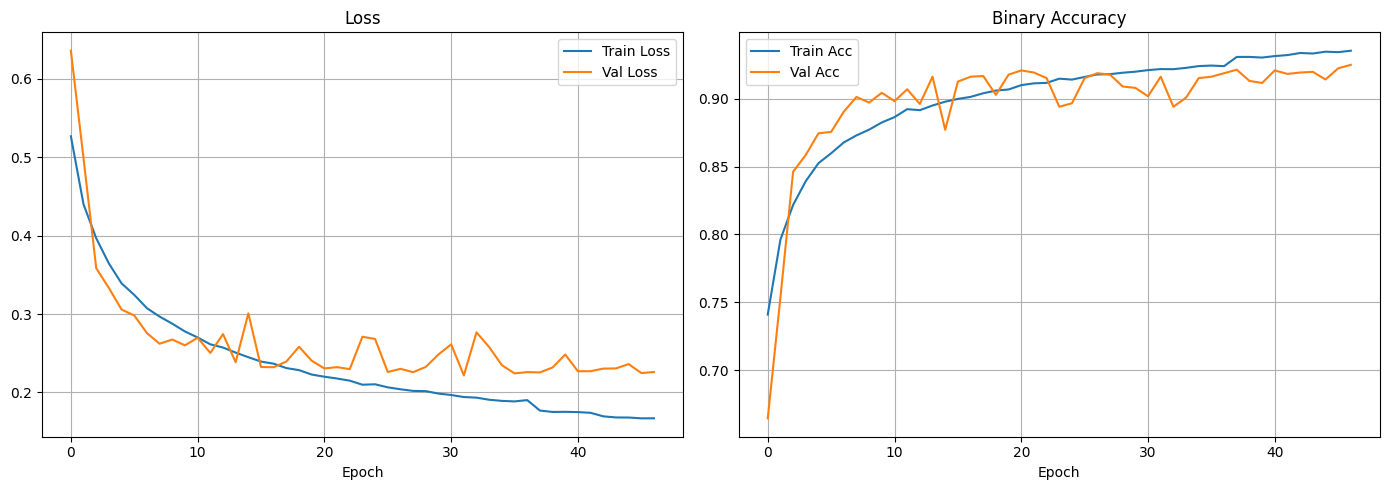

In [ ]:
#@title Графики обучения

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['binary_accuracy'], label='Train Acc')
axes[1].plot(history.history['val_binary_accuracy'], label='Val Acc')
axes[1].set_title('Binary Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#@title Детальная оценка на тестовом наборе

# Загружаем лучшую модель
model = keras.models.load_model('best_model.keras')

# Предсказания
y_pred = model.predict(X_test, verbose=0)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

# Метрики по ячейкам
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test.flatten(), y_pred_binary.flatten(), zero_division=0)
recall = recall_score(y_test.flatten(), y_pred_binary.flatten(), zero_division=0)
f1 = f1_score(y_test.flatten(), y_pred_binary.flatten(), zero_division=0)

print(f"Per-cell metrics:")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1:        {f1:.3f}")

# Метрика "обнаружение присутствия": есть ли хотя бы одна активная ячейка?
has_person_true = (y_test.sum(axis=1) > 0)
has_person_pred = (y_pred_binary.sum(axis=1) > 0)

presence_accuracy = (has_person_true == has_person_pred).mean()
print(f"\nPresence detection accuracy: {presence_accuracy:.1%}")

# Метрика "правильное направление": центроид предсказания vs ground truth
correct_direction = 0
total_with_person = 0
for i in range(len(y_test)):
    if y_test[i].sum() == 0:
        continue
    total_with_person += 1
    # Центроид ground truth
    gt_grid = y_test[i].reshape(GRID_SIZE, GRID_SIZE)
    pr_grid = y_pred_binary[i].reshape(GRID_SIZE, GRID_SIZE)
    if pr_grid.sum() == 0:
        continue
    gt_cy, gt_cx = np.where(gt_grid > 0)
    pr_cy, pr_cx = np.where(pr_grid > 0)
    # Среднее направление
    gt_dir_x = np.sign(gt_cx.mean() - 1)  # -1=left, 0=center, 1=right
    pr_dir_x = np.sign(pr_cx.mean() - 1)
    if gt_dir_x == pr_dir_x:
        correct_direction += 1

if total_with_person > 0:
    print(f"Horizontal direction accuracy: {correct_direction/total_with_person:.1%} ({correct_direction}/{total_with_person})")

Per-cell metrics:
  Precision: 0.877
  Recall:    0.831
  F1:        0.853

Presence detection accuracy: 97.2%
Horizontal direction accuracy: 80.2% (85/106)


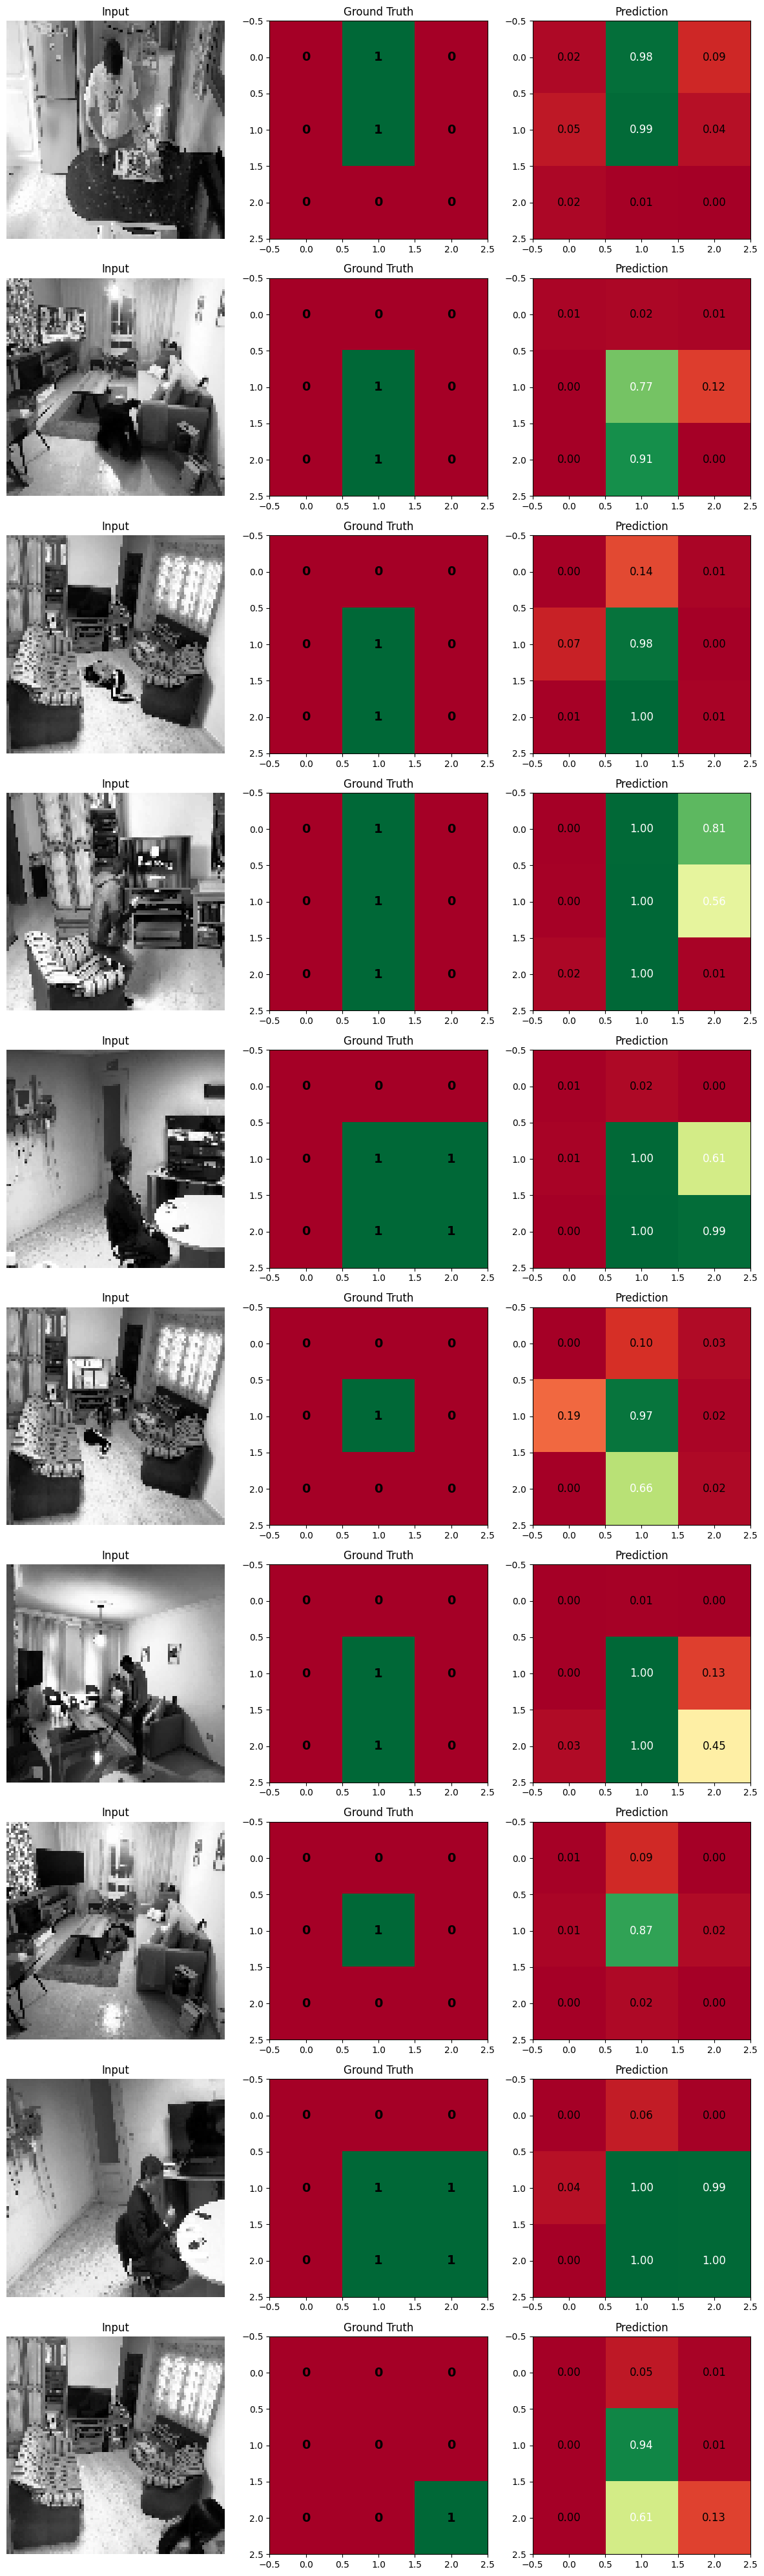

In [ ]:
#@title Визуализация предсказаний

n_show = 10
indices = np.random.choice(len(X_test), min(n_show, len(X_test)), replace=False)

fig, axes = plt.subplots(len(indices), 3, figsize=(12, 4*len(indices)))
if len(indices) == 1:
    axes = axes.reshape(1, -1)

for row, idx in enumerate(indices):
    img = X_test[idx].squeeze()
    gt = y_test[idx].reshape(GRID_SIZE, GRID_SIZE)
    pred = y_pred[idx].reshape(GRID_SIZE, GRID_SIZE)
    pred_bin = (pred > 0.5).astype(float)

    # Изображение
    axes[row, 0].imshow(img, cmap='gray')
    axes[row, 0].set_title('Input')
    axes[row, 0].axis('off')

    # Ground truth
    axes[row, 1].imshow(gt, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            axes[row, 1].text(gx, gy, f"{gt[gy,gx]:.0f}",
                            ha='center', va='center', fontsize=14, fontweight='bold')
    axes[row, 1].set_title('Ground Truth')

    # Prediction
    axes[row, 2].imshow(pred, cmap='RdYlGn', vmin=0, vmax=1, interpolation='nearest')
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            axes[row, 2].text(gx, gy, f"{pred[gy,gx]:.2f}",
                            ha='center', va='center', fontsize=12,
                            color='white' if pred[gy,gx] > 0.5 else 'black')
    axes[row, 2].set_title('Prediction')

plt.tight_layout()
plt.show()

---
## 7. Конвертация в TFLite (INT8 квантизация)

Полная int8 квантизация: вход и выход uint8, все веса int8.  
Это максимально быстро на ESP32 и минимально по размеру.

In [ ]:
# Конвертация с полной INT8 квантизацией
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset для калибровки квантизации
def representative_data_gen():
    # Используем 200 случайных сэмплов для калибровки
    n_samples = min(200, len(X_train))
    indices = np.random.choice(len(X_train), n_samples, replace=False)
    for i in indices:
        yield [X_train[i:i+1]]

converter.representative_dataset = representative_data_gen

# Полная INT8 квантизация (вход/выход тоже uint8)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

TFLITE_PATH = "person_grid_quant.tflite"
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)

size_bytes = len(tflite_model)
print(f"TFLite model size: {size_bytes:,} bytes ({size_bytes/1024:.1f} KB)")
print(f"Saved to: {TFLITE_PATH}")

Saved artifact at '/tmp/tmprdlvyy93'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  137596412948368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066067024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066066448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137596412952400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137596412950480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066066256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066067216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597065872208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066066832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597066067408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137597065885264: Tensor

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


TFLite model size: 18,976 bytes (18.5 KB)
Saved to: person_grid_quant.tflite


In [ ]:
#@title Валидация TFLite модели (убедимся, что квантизация не убила точность)

interpreter_tflite = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter_tflite.allocate_tensors()

input_details = interpreter_tflite.get_input_details()
output_details = interpreter_tflite.get_output_details()

print("Input details:", input_details[0])
print("Output details:", output_details[0])

# Тестируем на X_test
input_scale = input_details[0]['quantization'][0]
input_zp = input_details[0]['quantization'][1]
output_scale = output_details[0]['quantization'][0]
output_zp = output_details[0]['quantization'][1]

print(f"\nInput  quant: scale={input_scale}, zero_point={input_zp}")
print(f"Output quant: scale={output_scale}, zero_point={output_zp}")

y_pred_tflite = []
for i in range(len(X_test)):
    # Квантизуем вход
    sample = X_test[i:i+1]
    if input_details[0]['dtype'] == np.uint8:
        sample_q = np.clip(sample / input_scale + input_zp, 0, 255).astype(np.uint8)
    else:
        sample_q = sample.astype(np.float32)

    interpreter_tflite.set_tensor(input_details[0]['index'], sample_q)
    interpreter_tflite.invoke()
    output = interpreter_tflite.get_tensor(output_details[0]['index'])

    # Деквантизуем выход
    if output_details[0]['dtype'] == np.uint8:
        output_f = (output.astype(np.float32) - output_zp) * output_scale
    else:
        output_f = output.astype(np.float32)

    y_pred_tflite.append(output_f.flatten())

y_pred_tflite = np.array(y_pred_tflite)
y_pred_tflite_bin = (y_pred_tflite > 0.5).astype(np.float32)

# Сравниваем
p_tflite = precision_score(y_test.flatten(), y_pred_tflite_bin.flatten(), zero_division=0)
r_tflite = recall_score(y_test.flatten(), y_pred_tflite_bin.flatten(), zero_division=0)
f1_tflite = f1_score(y_test.flatten(), y_pred_tflite_bin.flatten(), zero_division=0)

print(f"\nTFLite INT8 per-cell metrics:")
print(f"  Precision: {p_tflite:.3f} (Keras: {precision:.3f})")
print(f"  Recall:    {r_tflite:.3f} (Keras: {recall:.3f})")
print(f"  F1:        {f1_tflite:.3f} (Keras: {f1:.3f})")

Input details: {'name': 'serving_default_image:0', 'index': 0, 'shape': array([ 1, 96, 96,  1], dtype=int32), 'shape_signature': array([-1, 96, 96,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
Output details: {'name': 'StatefulPartitionedCall_1:0', 'index': 45, 'shape': array([1, 9], dtype=int32), 'shape_signature': array([-1,  9], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

Input  quant: scale=0.003921568859368563, zero_point=0
Output quant: scale=0.00390625, zero_point=0

TFLite INT8 per-cell metrics:
  Precision: 0.882 (Keras: 0.877)
  Recall:    0.821 (Keras: 0.831)
  

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


---
## 8. Скачивание весов

In [ ]:
# Скачиваем веса
print("Файлы для ESP32-CAM проекта:")
print(f"  1. {TFLITE_PATH} ({os.path.getsize(TFLITE_PATH)/1024:.1f} KB) - TFLite модель")

# Создаём ZIP-архив
import zipfile
with zipfile.ZipFile('esp32_person_detector.zip', 'w') as zf:
    zf.write(TFLITE_PATH)

print("Создан архив: esp32_person_detector.zip")
print("\nНажмите кнопку ниже для скачивания:")
files.download('esp32_person_detector.zip')

Файлы для ESP32-CAM проекта:
  1. person_grid_quant.tflite (18.5 KB) - TFLite модель
  2. model_data.h - C-header для Arduino
  3. main.cpp - код для ESP32-CAM

Создан архив: esp32_person_detector.zip

Нажмите кнопку ниже для скачивания:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>